### 9.1 모형 결합
```
모형 결합(model combining) 방법은 앙상블 방법론(ensemble methods)이라고도 한다. 
이는 특정한 하나의 예측 방법이 아니라 복수의 예측 모형을 결합하여 더 나은 성능의 예측을 하려는 시도이다.
```

- 단일 모형을 사용할 때 보다 성능 분산이 감소하고, 즉 과최적화를 방지한다.
- 개별 모형이 성능이 안좋을 경우에는 결합 모형의 성능이 더 향상된다.

다수결 방법
```
다수결 방법은 가장 단순한 모형 결합 방법으로 전혀 다른 모형도 결합할 수 있다.
다수결 방법은 Hard Voting 과 Soft Voting 두 가지로 나뉘어진다.
```

- hard voting: 단순 투표. 개별 모형의 결과 기준
- soft voting: 가중치 투표. 개별 모형의 조건부 확률의 합 기준

In [10]:
import warnings
warnings.filterwarnings(action='ignore')

import scipy as sp
import scipy.stats
import statsmodels.api as sm
import sklearn as sk
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
import io
import pydot
from IPython.core.display import Image
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# 한글 나오도록 설정하기
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist]))
# 폰트 설정
mpl.rc('font', family='NanumGothic')
# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

In [8]:
from sklearn.ensemble import VotingClassifier

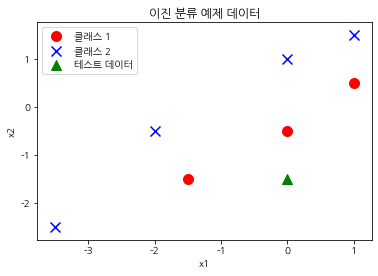

In [11]:
X = np.array([[0, -0.5], [-1.5, -1.5], [1, 0.5], [-3.5, -2.5], [0, 1], [1, 1.5], [-2, -0.5]])
y = np.array([1, 1, 1, 2, 2, 2, 2])
x_new = [0, -1.5]
plt.scatter(X[y == 1, 0], X[y == 1, 1], s=100, marker='o', c='r', label="클래스 1")
plt.scatter(X[y == 2, 0], X[y == 2, 1], s=100, marker='x', c='b', label="클래스 2")
plt.scatter(x_new[0], x_new[1], s=100, marker='^', c='g', label="테스트 데이터")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("이진 분류 예제 데이터")
plt.legend()
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

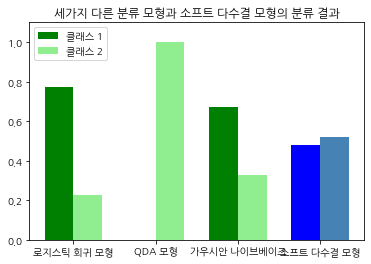

In [13]:
model1 = LogisticRegression(random_state=1)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
ensemble = VotingClassifier(estimators=[('lr', model1), ('qda', model2), ('gnb', model3)], voting='soft')

probas = [c.fit(X, y).predict_proba([x_new]) for c in (model1, model2, model3, ensemble)]
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

ind = np.arange(4)
width = 0.35  # bar width
p1 = plt.bar(ind, np.hstack(([class1_1[:-1], [0]])), width, color='green')
p2 = plt.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width, color='lightgreen')
p3 = plt.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = plt.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')

plt.xticks(ind + 0.5 * width, ['로지스틱 회귀 모형', 'QDA 모형', '가우시안 나이브베이즈', '소프트 다수결 모형'])
plt.ylim([0, 1.1])
plt.title('세가지 다른 분류 모형과 소프트 다수결 모형의 분류 결과')
plt.legend([p1[0], p2[0]], ['클래스 1', '클래스 2'], loc='upper left')
plt.show()

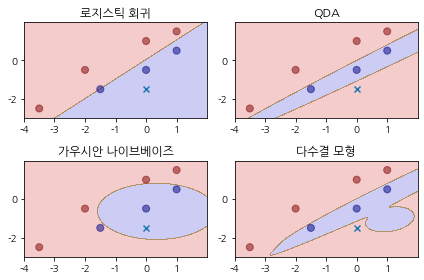

In [14]:
from itertools import product

x_min, x_max = -4, 2
y_min, y_max = -3, 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.005),
                     np.arange(y_min, y_max, 0.005))
f, axarr = plt.subplots(2, 2)
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [model1, model2, model3, ensemble],
                        ['로지스틱 회귀', 'QDA', '가우시안 나이브베이즈', '다수결 모형']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.2, cmap=mpl.cm.jet)
    axarr[idx[0], idx[1]].scatter(
        X[:, 0], X[:, 1], c=y, alpha=0.5, s=50, cmap=mpl.cm.jet)
    axarr[idx[0], idx[1]].scatter(x_new[0], x_new[1], marker='x')
    axarr[idx[0], idx[1]].set_title(tt)
plt.tight_layout()
plt.show()

#### 모형 결합을 사용한 성능 향상
```
만약 개별 모형이 정답을 출력할 확률이  p 인 경우에 
서로 다르고 독립적인 모형을  N 개 모아서 다수결 모형을 만들면 
정답을 출력할 확률이 다음과 같아진다.

(k>N/2 ~ N)∑(N C k) * p^k * (1−p)^(N−k)
```

In [19]:
from scipy.special import comb

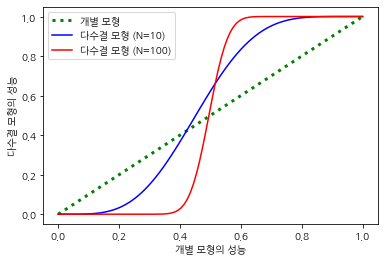

In [21]:
def total_error(p, N):
    te = 0.0
    for k in range(int(np.ceil(N/2)), N + 1):
        te += comb(N, k) * p**k * (1-p)**(N-k)
    return te


x = np.linspace(0, 1, 100)
plt.plot(x, x, 'g:', lw=3, label="개별 모형")
plt.plot(x, total_error(x, 10), 'b-', label="다수결 모형 (N=10)")
plt.plot(x, total_error(x, 100), 'r-', label="다수결 모형 (N=100)")
plt.xlabel("개별 모형의 성능")
plt.ylabel("다수결 모형의 성능")
plt.legend(loc=0)
plt.show()

In [23]:
# 성능이 40점인 모형이 여럿모이면 오히려 성능이 더 낮아짐,,
# 정도껏 낮아야...(50점 이상인 성능을 많이 모아야!)

In [24]:
# 성향이 비슷한 모형이 모여봤자 비슷한 모형이 나오니까 독립적인 모형이 모여야

#### 연습 문제 1
```
Iris 분류 문제를 다수결 방법을 사용하여 풀어라. 
모형의 종류 및 개수나 다수결 방법은 마음대로 한다. 
K=5인 교차 검증을 하였을 때 성능의 평균과 표준편차를 구하라.
```

In [32]:
from sklearn.datasets import load_iris

In [39]:
iris=load_iris().data

In [55]:
iris_target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [41]:
iris_target=load_iris().target

In [44]:
from sklearn.model_selection import train_test_split

In [60]:
model1 = LogisticRegression(random_state=1)
model2 = QuadraticDiscriminantAnalysis()
model3 = GaussianNB()
model4 = LinearDiscriminantAnalysis()
model5 = DecisionTreeClassifier(criterion="entropy",max_depth=3,random_state=0)
ensemble = VotingClassifier(estimators=[('lr', model1), ('qda', model2), ('gnb', model3),('lda', model4),('Tree', model5)], voting='soft')

In [61]:
from sklearn.model_selection import cross_val_score, KFold

In [62]:
from sklearn.tree import DecisionTreeClassifier

In [63]:
cv=KFold(5,shuffle=True,random_state=0)

In [64]:
cross_val_score(ensemble,iris,iris_target,scoring="accuracy",cv=cv).mean()

0.9666666666666666